# Self Driving Car Using VGG 16

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import pi
from itertools import islice
import cv2
import tensorflow as tf
import pickle

In [2]:
#reading the data set from data.txt

dataset_path='H:\Case Study\Self Driving Case Study\Autopilot-TensorFlow-master\Autopilot-TensorFlow-master\driving_dataset'
training_path=os.path.join(dataset_path,'data.txt')

split=0.8
X=[]
y=[]

#islice(text, start, stop, LIMIT) --> ('ABCDEF', 2, None) --> 'C D E F'  -->https://docs.python.org/2/library/itertools.html
with open(training_path) as f:
    for line in islice(f,None):
        path,angle=line.strip().split()
        full_path=os.path.join(dataset_path,path)
        X.append(full_path)
        y.append((float(angle)*pi)/180)
        
y=np.array(y)

print("Finished Preprocessing")

#split it with 80/20

split_index=int(len(y)*0.8)
y_train=y[:split_index]
y_val=y[split_index:]

Finished Preprocessing


In [3]:
#Model 0: Base line Model: y_test_pred = mean(y_train_i) 
train_mean_y = np.mean(y_train)

print('Test_MSE(MEAN):%f' % np.mean(np.square(y_val-train_mean_y)) )
print('Test_MSE(ZERO):%f' % np.mean(np.square(y_val-0.0)) )

Test_MSE(MEAN):0.191127
Test_MSE(ZERO):0.190891


In [4]:
print(len(y_train))
print(len(y_val))

36324
9082


In [5]:
print(len(X[:len(y_train)]))
print(len(X[len(y_train):]))

36324
9082


In [37]:
print(X[0])

H:\Case Study\Self Driving Case Study\Autopilot-TensorFlow-master\Autopilot-TensorFlow-master\driving_dataset\0.jpg


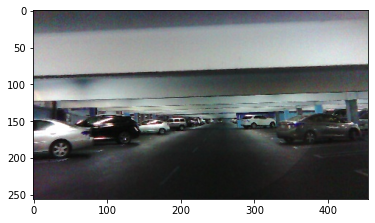

In [7]:
import cv2
img=cv2.imread(X[0])

plt.imshow(img)
plt.show()

#### Observation: VGG 16 uses image size of 224,224. Whereas in our case the size is different.

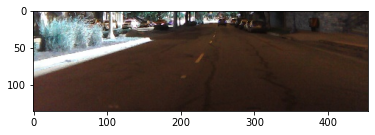

******************************
shape after resizing it: (224, 350, 3)


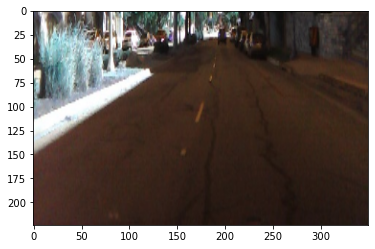

(224, 350, 3)


In [41]:
#Nvidia requires us to give an input of image of size 66,200
# Figuring out the portion of images to be removed.

img=cv2.imread(X[1500])
img=img[120:]
plt.imshow(img)
plt.show()
print('******************************')
resized_img = cv2.resize(img, (350,224))  # 200/66 = 455/150 = 3.03 => we are keeping aspect ratio when we are resizing it
print('shape after resizing it:', resized_img.shape)
plt.imshow(resized_img)
plt.show()
print(resized_img.shape)

In [42]:
X_train=[]
for i in X[:len(y_train)]:
    img=cv2.imread(i)
    img=img[120:]
    resized_img=cv2.resize(img,(350,224))
    X_train.append(resized_img)

In [43]:
X_train=np.array(X_train)

In [50]:
X_train_new=X_train.astype('float32')

MemoryError: Unable to allocate 31.8 GiB for an array with shape (36324, 224, 350, 3) and data type float32

In [45]:
X_val = []
for j in X[len(y_train):]:
    img = cv2.imread(i)
    X_val.append(img)

In [46]:
X_val = np.array(X_val)

In [49]:
type(X_train)

numpy.ndarray

## Preparing data for modelling

In [47]:
img_rows = X_train.shape[1]
img_cols = X_train.shape[2]
channels = X_train.shape[3]

print(img_rows, img_cols, channels)

224 350 3


In [48]:
import tensorflow.keras.backend as K

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], channels, img_rows, img_cols).astype('float32')
    X_val = X_val.reshape(X_val.shape[0], channels, img_rows, img_cols).astype('float32')
    img_size = (channels, img_rows, img_cols)
    
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, channels).astype('float32')
    X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, channels).astype('float32')
    img_size = (img_rows, img_cols, channels)

MemoryError: Unable to allocate 31.8 GiB for an array with shape (36324, 224, 350, 3) and data type float32

In [ ]:
X_train = X_train/255.0
X_val = X_val/255.0

## Building model from VGG16 Architecture

In [ ]:
def get_conv_nvidia(self,input_img):
    img_input = tf.keras.Input(input_img)
    x = tf.keras.layers.Conv2D(filters=24, kernel_size=(5,5), strides=(2,2), padding='valid', name='conv-1')(batch_input)
    x = tf.keras.layers.Conv2D(filters=36, kernel_size=(5,5), strides=(2,2), padding='valid', name='conv-2')(x)
    x = tf.keras.layers(tf.keras.layers.BatchNormalization())(x)
    x = tf.keras.layers.Conv2D(filters=48, kernel_size=(5,5), strides=(2,2), padding='valid', name='conv-3')(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid', name='conv-4')(x)
    x = tf.keras.layers(tf.keras.layers.BatchNormalization())(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid', name='conv-5')(x)
    conv_model = tf.keras.layers.Flatten(name='flatten')(x)
    
    return conv_model

In [ ]:
def create_network(self,Nvidia):
    
    if model_name == 'Nvidia':
        
        image_features = self.get_conv_nvidia(input_img)
        lstm_network = tf.keras.layers.LSTM(number_of_hiddenunits, return_sequences=True,dropout=0.5,recurrent_dropout=0.5)(image_features)
        lstm_network = tf.keras.layers.LSTM(number_of_hiddenunits, return_sequences=False,dropout=0.5,recurrent_dropout=0.5)(lstm_network)
        lstm_network = tf.keras.layers.Dense(1024,activation='relu')(lstm_network)
        lstm_network = tf.keras.layers.BatchNormalization()(lstm_network)
        lstm_network = tf.keras.layers.Dropout(0.5)(lstm_network)
        lstm_network = tf.keras.layers.Dense(512,activation='relu')(lstm_network)
        lstm_network = tf.keras.layers.Dropout(0.5)(lstm_network)
        lstm_network = tf.keras.layers.Dense(64,activation='relu')(lstm_network)
        lstm_network = tf.keras.layers.Dropout(0.5)(lstm_network)    
        output = tf.keras.layers.Dense(n_classes,activation='atan')(lstm_network)
            
        model_2 = tf.keras.models.Model(inputs=img_input, outputs=output, name='model-2')